In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import torch
import pyreadr
import requests
import urllib.request
import math
import pandas as pd 
import random
import numpy as np
from sklearn.datasets import load_iris 
from scipy.ndimage import gaussian_filter
from sklearn import preprocessing
from sklearn import utils

    
import statistics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn import svm
from torchvision import datasets, transforms
from sklearn import neighbors
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# We intend to predict the AC Power
# It should be done using Ambient temperature, module temperature, irradiation and time of day, because we these are forecasted
# The ML algorithm should only be trained on the above.

In [3]:
#Plant 1 datasets
P1G=pd.read_csv('Plant_1_Generation_Data.csv',na_values= '?')
P1W=pd.read_csv('Plant_1_Weather_Sensor_Data.csv',na_values= '?')

#Plant 2 datasets
P2G=pd.read_csv('Plant_2_Generation_Data.csv',na_values= '?')
P2W=pd.read_csv('Plant_2_Weather_Sensor_Data.csv',na_values= '?')

#Check for missing values, commented out because of no missing values. Imputation not necessary
#for col in range(P1W.shape[1]):
    # YOUR CODE HERE
#    n_miss = P1W.iloc[:, col].isna().sum()
#    print('Column {} has {} missing values.'.format(col, n_miss))
#P2G.isna().sum()
#P2W.dtypes
display(P2W)
display(P2G)

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,4136001,iq8k7ZNt4Mwm3w0,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,4136001,iq8k7ZNt4Mwm3w0,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,4136001,iq8k7ZNt4Mwm3w0,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,4136001,iq8k7ZNt4Mwm3w0,26.596148,25.088210,0.0
...,...,...,...,...,...,...
3254,2020-06-17 22:45:00,4136001,iq8k7ZNt4Mwm3w0,23.511703,22.856201,0.0
3255,2020-06-17 23:00:00,4136001,iq8k7ZNt4Mwm3w0,23.482282,22.744190,0.0
3256,2020-06-17 23:15:00,4136001,iq8k7ZNt4Mwm3w0,23.354743,22.492245,0.0
3257,2020-06-17 23:30:00,4136001,iq8k7ZNt4Mwm3w0,23.291048,22.373909,0.0


,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
1,2020-05-15 00:00:00,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2,2020-05-15 00:00:00,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
3,2020-05-15 00:00:00,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
4,2020-05-15 00:00:00,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07
...,...,...,...,...,...,...,...
67693,2020-06-17 23:45:00,4136001,q49J1IKaHRwDQnt,0.0,0.0,4157.000000,5.207580e+05
67694,2020-06-17 23:45:00,4136001,rrq4fwE8jgrTyWY,0.0,0.0,3931.000000,1.211314e+08
67695,2020-06-17 23:45:00,4136001,vOuJvMaM2sgwLmb,0.0,0.0,4322.000000,2.427691e+06
67696,2020-06-17 23:45:00,4136001,xMbIugepa2P7lBB,0.0,0.0,4218.000000,1.068964e+08


In [4]:
#Copying generation and weather data from plant 1
generation_data=P1G.copy()
weather_data=P1W.copy()

#Converting the DATE_TIME to a pandas datetime object
generation_data['DATE_TIME'] = pd.to_datetime(generation_data["DATE_TIME"])
weather_data['DATE_TIME'] = pd.to_datetime(weather_data["DATE_TIME"])

#Merging the 2 datasets and adding a column that contains the time of day in one column, which is more convenient for training.
df = pd.merge(generation_data.drop(columns=['PLANT_ID']), weather_data.drop(columns=['PLANT_ID', 'SOURCE_KEY']), on='DATE_TIME')
df['HOUR'] = pd.to_datetime(df['DATE_TIME'].astype(str)).dt.hour+(pd.to_datetime(df['DATE_TIME'].astype(str)).dt.minute)/60

#Dropping parameters, not usable for predicting AC_POWER
df=df.drop(['DATE_TIME','SOURCE_KEY','DC_POWER','DAILY_YIELD','TOTAL_YIELD'],axis=1)

#Show dataframe
df

,AC_POWER,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,HOUR
0,0.0,25.184316,22.857507,0.0,0.00
1,0.0,25.184316,22.857507,0.0,0.00
2,0.0,25.184316,22.857507,0.0,0.00
3,0.0,25.184316,22.857507,0.0,0.00
4,0.0,25.184316,22.857507,0.0,0.00
...,...,...,...,...,...
45675,0.0,21.909288,20.427972,0.0,23.75
45676,0.0,21.909288,20.427972,0.0,23.75
45677,0.0,21.909288,20.427972,0.0,23.75
45678,0.0,21.909288,20.427972,0.0,23.75


In [5]:
#max(df['AC_POWER'])

#Min max scale the data
#Making scaler
scaler=MinMaxScaler()
#Fitting scaler to the data
scaler.fit(df)
#Transform the data to values between 0 and 1
df_min_max=pd.DataFrame(scaler.transform(df))
#The transform removes the column labels, we therefore apply them again:
df_min_max.rename(columns={0: "AC_Power", 1: "Ambient_temperature", 2: "Module_temperature",3:"Irradiation",4:"Hour"},inplace=True)
display(df_min_max)

,AC_Power,Ambient_temperature,Module_temperature,Irradiation,Hour
0,0.0,0.322190,0.099506,0.0,0.0
1,0.0,0.322190,0.099506,0.0,0.0
2,0.0,0.322190,0.099506,0.0,0.0
3,0.0,0.322190,0.099506,0.0,0.0
4,0.0,0.322190,0.099506,0.0,0.0
...,...,...,...,...,...
45675,0.0,0.101709,0.048255,0.0,1.0
45676,0.0,0.101709,0.048255,0.0,1.0
45677,0.0,0.101709,0.048255,0.0,1.0
45678,0.0,0.101709,0.048255,0.0,1.0


In [6]:
y=df_min_max['AC_Power']
x=df_min_max.drop(['AC_Power'],axis=1)
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y)
print(np.shape(y))
print(np.shape(y_transformed))
print('y_transformed:',y_transformed)
print('x:',x)
X_train, X_test, y_train, y_test= train_test_split(x, y_transformed, test_size=0.25, random_state=42)

(45680,)
(45680,)
y_transformed: [0 0 0 ... 0 0 0]
x:        Ambient_temperature  Module_temperature  Irradiation  Hour
0                 0.322190            0.099506          0.0   0.0
1                 0.322190            0.099506          0.0   0.0
2                 0.322190            0.099506          0.0   0.0
3                 0.322190            0.099506          0.0   0.0
4                 0.322190            0.099506          0.0   0.0
...                    ...                 ...          ...   ...
45675             0.101709            0.048255          0.0   1.0
45676             0.101709            0.048255          0.0   1.0
45677             0.101709            0.048255          0.0   1.0
45678             0.101709            0.048255          0.0   1.0
45679             0.101709            0.048255          0.0   1.0

[45680 rows x 4 columns]


In [19]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
#############################################
#Loop settings
neighb=100
k_folds=10


#knn = KNeighborsClassifier(n_neighbors=1)
knn = neighbors.KNeighborsRegressor(n_neighbors=1)
cv_scores=cross_val_score(knn, x, y_transformed, cv=k_folds)

for i in range(2,neighb+1):
    #knn = KNeighborsClassifier(n_neighbors=i)
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
    #train model with cv of 5 
    cv_scores = np.append(cv_scores,cross_val_score(knn, x, y_transformed, cv=k_folds))
    print('i:{}'.format(i))

i:2
i:3
i:4
i:5
i:6
i:7
i:8
i:9
i:10
i:11
i:12
i:13
i:14
i:15
i:16
i:17
i:18
i:19
i:20
i:21
i:22
i:23
i:24
i:25
i:26
i:27
i:28
i:29
i:30
i:31
i:32
i:33
i:34
i:35
i:36
i:37
i:38
i:39
i:40
i:41
i:42
i:43
i:44
i:45
i:46
i:47
i:48
i:49
i:50
i:51
i:52
i:53
i:54
i:55
i:56
i:57
i:58
i:59
i:60
i:61
i:62
i:63
i:64
i:65
i:66
i:67
i:68
i:69
i:70
i:71
i:72
i:73
i:74
i:75
i:76
i:77
i:78
i:79
i:80
i:81
i:82
i:83
i:84
i:85
i:86
i:87
i:88
i:89
i:90
i:91
i:92
i:93
i:94
i:95
i:96
i:97
i:98
i:99
i:100


In [20]:
scores = np.reshape(cv_scores,(neighb,k_folds))
StanDev = np.zeros(neighb)
RowMeans= np.zeros(neighb)
for i in range(neighb):
    StanDev[i]=statistics.stdev(scores[i])
    RowMeans[i]=np.mean(scores[i])
    #print(scores[i])
print("standard deviation:\n{}".format(StanDev))
print("Means for k=1:10:\n {}".format(RowMeans))


#knn_train = KNeighborsClassifier(n_neighbors=1)
knn_train = neighbors.KNeighborsRegressor(n_neighbors=1)
knn_train.fit(x,y_transformed)
train_scores=knn_train.score(x,y_transformed)

for i in range(2,neighb+1):
    #knn_train = KNeighborsClassifier(n_neighbors=i)
    knn_train = neighbors.KNeighborsRegressor(n_neighbors=i)
    knn_train.fit(x,y_transformed)
    train_scores=np.append(train_scores,knn_train.score(x,y_transformed))

standard deviation:
[0.02178525 0.01242392 0.01157299 0.01060903 0.01161535 0.01083724
 0.01028913 0.01017932 0.01024581 0.01031365 0.01008382 0.0099811
 0.01005286 0.01006711 0.01005504 0.01011599 0.01006278 0.01007711
 0.01006549 0.01002765 0.01003513 0.01007525 0.01010627 0.01017039
 0.01016727 0.01014294 0.01013383 0.010116   0.01012876 0.01008991
 0.01008496 0.01005645 0.01002308 0.01005234 0.01006263 0.01008859
 0.0100638  0.01009545 0.01008646 0.01008844 0.01009435 0.01010538
 0.01010263 0.01012648 0.0101425  0.0101548  0.01015781 0.01018812
 0.01022951 0.01023893 0.01025466 0.01027919 0.01031087 0.01031382
 0.01033453 0.01035912 0.01037877 0.01039629 0.01041876 0.0104392
 0.01046222 0.01046415 0.01048963 0.01047507 0.01052618 0.01053711
 0.01052373 0.01049765 0.01050205 0.01050631 0.01049242 0.01048071
 0.01047988 0.01048383 0.01046832 0.01046295 0.01047578 0.01047489
 0.01048385 0.01048163 0.01047954 0.0104712  0.01047085 0.01047396
 0.01047454 0.01045503 0.01047231 0.01048223

(100,)
[0.96727913 0.98388505 0.98666968 0.98783689 0.98885633 0.98901339
 0.9890553  0.98932304 0.98941374 0.98956401 0.98955612 0.9895043
 0.98974534 0.98982779 0.98999639 0.99010992 0.99018401 0.9902513
 0.9902972  0.99032565 0.99035178 0.99037716 0.99032091 0.99027084
 0.99018338 0.99007273 0.98998414 0.98986106 0.98971921 0.98960665
 0.98946593 0.98935279 0.98924068 0.98907189 0.9889641  0.98884984
 0.98873797 0.98863727 0.98856484 0.98847925 0.98838456 0.98828181
 0.98819201 0.98809293 0.98811894 0.98814692 0.98814429 0.98814828
 0.98815369 0.98814231 0.98813381 0.98813164 0.98809746 0.98808607
 0.98804598 0.98800801 0.98796934 0.98793135 0.98791037 0.9878808
 0.98783798 0.98778767 0.98775321 0.98770724 0.98766331 0.98762948
 0.98763654 0.98765384 0.987666   0.98767282 0.98766659 0.98765039
 0.98765716 0.9876501  0.98763681 0.98762191 0.98759606 0.98757569
 0.9875534  0.98753403 0.98750854 0.98748525 0.98746609 0.98743078
 0.98740734 0.98738614 0.98735273 0.98732563 0.98732594 0.

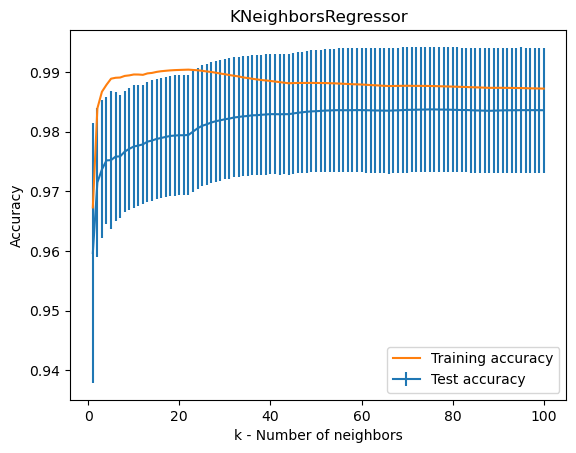

In [26]:
ks=np.arange(1,neighb+1)
print(np.shape(ks))
print(train_scores)
print(np.where(RowMeans==max(RowMeans)))
print("Unique labels",len(np.unique(y_transformed)))
print("Number of labels",len(y_transformed))
plt.errorbar(ks, RowMeans,yerr=StanDev)
plt.plot(ks,train_scores)
plt.xlabel('k - Number of neighbors')
plt.legend(['Training accuracy','Test accuracy'],loc=4)
plt.title('KNeighborsRegressor')
plt.ylabel('Accuracy')
#plt.axis([0, neighbors, 0.4, 0.6])
plt.show()

In [10]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


lr_score = lr_model.score(X_test, y_test)
print(f"Score is {lr_score*100:.4f} %")

Score is 97.9674 %


In [11]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


from sklearn import neighbors

score_list = []
n_neighbors_list = []

# for loop to find best fitting n_neighbor value
for i in range(1, 21):
    knn = neighbors.KNeighborsRegressor(n_neighbors=i)
    knn.fit(X_train, y_train)

    knn_score = knn.score(X_test, y_test)

    score_list.append(knn_score)
    n_neighbors_list.append(i)

best_n_neighbor = n_neighbors_list[score_list.index(max(score_list))]
print(f"Best n_neighbor at {best_n_neighbor} with {max(score_list)*100:.4f} %")


Best n_neighbor at 16 with 99.0145 %


In [12]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(X_train,y_train)

dtr_score = dtr.score(X_test, y_test)
print(f"Score is {dtr_score*100:.4f} %")

Score is 99.0281 %


In [13]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)

rfr_score = rfr.score(X_test, y_test)
print(f"Score is {rfr_score*100:.4f} %")

Score is 99.0269 %
